In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')

from functions.split_dataset import split_dataset, prepare_to_eval
from functions.create_model import create_model_bilstmcrf

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from seqeval.metrics import f1_score, classification_report, accuracy_score
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow_addons.losses import SigmoidFocalCrossEntropy

2022-08-18 00:54:24.238329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 00:54:24.238365: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-08-18 00:54:26.577789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 00:54:26.629552: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-18 00:54:26.629588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (meilux): /proc/driver/nvidia/version does not exist


In [3]:
dataset_path = '../../data/trivia10k13train.bio.csv'

df = pd.read_csv(dataset_path, sep="\t", skip_blank_lines=False)
df[:20]

,Tag,Text
0,B-Actor,steve
1,I-Actor,mcqueen
2,O,provided
3,O,a
4,B-Plot,thrilling
5,I-Plot,motorcycle
6,I-Plot,chase
7,I-Plot,in
8,I-Plot,this
9,B-Opinion,greatest


In [4]:
id_list = []
id = 0

def isNaN(string):
    return string != string

for tag, text in zip(df['Tag'], df['Text']):
    if isNaN(tag):
        id += 1
    id_list.append(id)

df['id'] = id_list
df = df.dropna()
df[:20]

,Tag,Text,id
0,B-Actor,steve,0
1,I-Actor,mcqueen,0
2,O,provided,0
3,O,a,0
4,B-Plot,thrilling,0
5,I-Plot,motorcycle,0
6,I-Plot,chase,0
7,I-Plot,in,0
8,I-Plot,this,0
9,B-Opinion,greatest,0


In [5]:
df.head()

,Tag,Text,id
0,B-Actor,steve,0
1,I-Actor,mcqueen,0
2,O,provided,0
3,O,a,0
4,B-Plot,thrilling,0


In [6]:
df['Text'].astype(str)

0             steve
1           mcqueen
2          provided
3                 a
4         thrilling
            ...    
166633           on
166634            a
166635     nicholas
166636       sparks
166637        novel
Name: Text, Length: 158822, dtype: object

In [7]:
all_documents = list(set(df["id"].values))
num_documents = len(all_documents)

all_tags = list(set(df["Tag"].values))
NUM_TAGS = len(all_tags)

all_words = list(set(df["Text"].values))
VOCAB_SIZE = len(all_words)

print(f'Quantidade de documentos: {num_documents}')
print(f'Number of unique words: {VOCAB_SIZE}')
print(f'Quantidade de tags: {NUM_TAGS}')

Quantidade de documentos: 7816
Number of unique words: 10986
Quantidade de tags: 25


<AxesSubplot:>

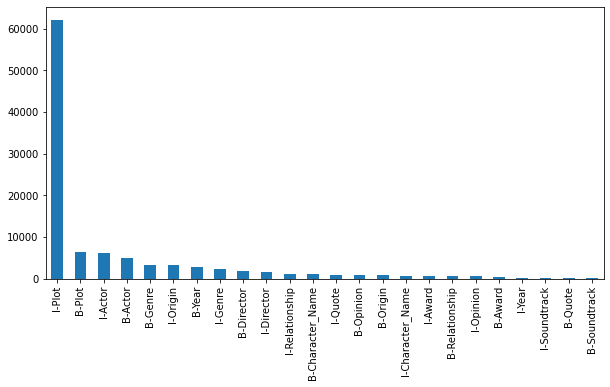

In [8]:
df[df["Tag"]!="O"]["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

(7816, 1)

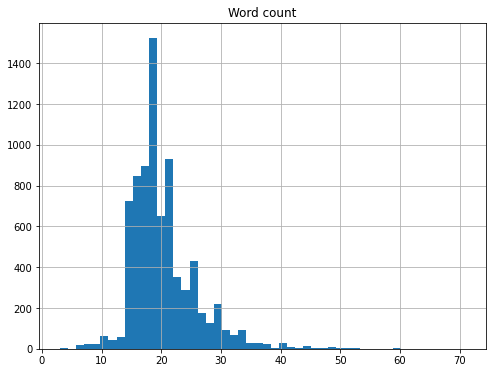

In [9]:
word_counts = df.groupby("id")["Text"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6))
word_counts.shape

In [10]:
MAX_SENTENCE = word_counts.max()[0]
print(f'Longest sentence contains {MAX_SENTENCE} words.')

Longest sentence contains 71 words.


In [11]:
tag_idx_dict = {tag: idx for idx, tag in enumerate(all_tags)}
idx_tag_dict = {idx: tag for idx, tag in enumerate(all_tags)}

tag_idx_dict

{'I-Origin': 0,
 'I-Quote': 1,
 'B-Opinion': 2,
 'B-Award': 3,
 'I-Opinion': 4,
 'O': 5,
 'I-Relationship': 6,
 'B-Character_Name': 7,
 'B-Origin': 8,
 'B-Plot': 9,
 'I-Actor': 10,
 'I-Genre': 11,
 'B-Year': 12,
 'I-Character_Name': 13,
 'I-Plot': 14,
 'I-Director': 15,
 'I-Soundtrack': 16,
 'I-Award': 17,
 'B-Quote': 18,
 'B-Genre': 19,
 'B-Actor': 20,
 'B-Soundtrack': 21,
 'I-Year': 22,
 'B-Director': 23,
 'B-Relationship': 24}

In [12]:
def to_tuples(data):
    iterator = zip(data["Text"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, tag) for word, tag in iterator]

sentences = df.groupby("id").apply(to_tuples).tolist()

print(sentences[0][:10])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion')]


In [13]:
df_idx = pd.DataFrame()

df_idx['invoice_id'] = list(set(df['id']))
df_idx['text_tag'] = sentences

In [14]:
df_idx.head()

,invoice_id,text_tag
0,0,"[(steve, B-Actor), (mcqueen, I-Actor), (provid..."
1,1,"[(liza, B-Actor), (minnelli, I-Actor), (and, O..."
2,2,"[(what, O), (is, O), (that, O), (tom, B-Actor)..."
3,3,"[(what, O), (is, O), (the, O), (movie, O), (ma..."
4,4,"[(i, O), (am, O), (thinking, O), (of, O), (an,..."


In [15]:
df_idx['text']=df_idx['text_tag'].apply(lambda text_tag:" ".join([str(s[0]) for s in text_tag]))
df_idx['tag']=df_idx['text_tag'].apply(lambda text_tag:" ".join([str(s[1]) for s in text_tag]))

In [16]:
df_idx.head()

,invoice_id,text_tag,text,tag
0,0,"[(steve, B-Actor), (mcqueen, I-Actor), (provid...",steve mcqueen provided a thrilling motorcycle ...,B-Actor I-Actor O O B-Plot I-Plot I-Plot I-Plo...
1,1,"[(liza, B-Actor), (minnelli, I-Actor), (and, O...",liza minnelli and joel gray won oscars for the...,B-Actor I-Actor O B-Actor I-Actor B-Award I-Aw...
2,2,"[(what, O), (is, O), (that, O), (tom, B-Actor)...",what is that tom hanks and julia roberts movie...,O O O B-Actor I-Actor O B-Actor I-Actor O O B-...
3,3,"[(what, O), (is, O), (the, O), (movie, O), (ma...",what is the movie making fun of macgyver by re...,O O O O B-Plot I-Plot I-Plot I-Plot I-Plot I-P...
4,4,"[(i, O), (am, O), (thinking, O), (of, O), (an,...",i am thinking of an animated film based on a c...,O O O O O B-Genre O B-Origin I-Origin I-Origin...


In [17]:
df_idx.shape

(7816, 4)

In [18]:
df_idx['tokenized_text']=df_idx['text'].apply(lambda x:x.split())
df_idx['tag_list']=df_idx['tag'].apply(lambda x:x.split())
df_idx.head()

,invoice_id,text_tag,text,tag,tokenized_text,tag_list
0,0,"[(steve, B-Actor), (mcqueen, I-Actor), (provid...",steve mcqueen provided a thrilling motorcycle ...,B-Actor I-Actor O O B-Plot I-Plot I-Plot I-Plo...,"[steve, mcqueen, provided, a, thrilling, motor...","[B-Actor, I-Actor, O, O, B-Plot, I-Plot, I-Plo..."
1,1,"[(liza, B-Actor), (minnelli, I-Actor), (and, O...",liza minnelli and joel gray won oscars for the...,B-Actor I-Actor O B-Actor I-Actor B-Award I-Aw...,"[liza, minnelli, and, joel, gray, won, oscars,...","[B-Actor, I-Actor, O, B-Actor, I-Actor, B-Awar..."
2,2,"[(what, O), (is, O), (that, O), (tom, B-Actor)...",what is that tom hanks and julia roberts movie...,O O O B-Actor I-Actor O B-Actor I-Actor O O B-...,"[what, is, that, tom, hanks, and, julia, rober...","[O, O, O, B-Actor, I-Actor, O, B-Actor, I-Acto..."
3,3,"[(what, O), (is, O), (the, O), (movie, O), (ma...",what is the movie making fun of macgyver by re...,O O O O B-Plot I-Plot I-Plot I-Plot I-Plot I-P...,"[what, is, the, movie, making, fun, of, macgyv...","[O, O, O, O, B-Plot, I-Plot, I-Plot, I-Plot, I..."
4,4,"[(i, O), (am, O), (thinking, O), (of, O), (an,...",i am thinking of an animated film based on a c...,O O O O O B-Genre O B-Origin I-Origin I-Origin...,"[i, am, thinking, of, an, animated, film, base...","[O, O, O, O, O, B-Genre, O, B-Origin, I-Origin..."


In [19]:
texts_list=df_idx['text'].tolist()
tags_list=df_idx['tag_list'].tolist()

In [20]:
tokenizer = Tokenizer(lower=False, filters='!?~[]()^_{"}\'%')
tokenizer.fit_on_texts(texts_list)
encoded_text_list = tokenizer.texts_to_sequences(texts_list)

print("Vocab size of Tokenizer ",len(tokenizer.word_index)+1)

Vocab size of Tokenizer  10987


In [21]:
encoded_tags_list = [[tag_idx_dict[w] for w in tag] for tag in tags_list]

In [22]:
padded_encoded_text_list = pad_sequences(maxlen=MAX_SENTENCE, sequences=encoded_text_list, padding="post", value=0)
padded_encoded_tags_list = pad_sequences(maxlen=MAX_SENTENCE, sequences=encoded_tags_list, padding="post", value=tag_idx_dict['O'])

In [23]:
dummy_tags = [to_categorical(i, num_classes=NUM_TAGS) for i in padded_encoded_tags_list]

In [24]:
# Train-val-test split
X, y = split_dataset(padded_encoded_text_list, dummy_tags)

train: 70%
val: 10%
test: 20%


In [25]:
model = create_model_bilstmcrf(MAX_SENTENCE, VOCAB_SIZE, NUM_TAGS)

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), 
                loss=SigmoidFocalCrossEntropy(), 
                metrics=['accuracy'])

history = model.fit(X['train'],
                    np.array(y['train']), 
                    validation_data=(X['val'], np.array(y['val'])),
                    batch_size=8,
                    callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
                    epochs=20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 71)]              0         
                                                                 
 embedding (Embedding)       (None, 71, 50)            549350    
                                                                 
 bidirectional (Bidirectiona  (None, 71, 60)           19440     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 71, 60)            0         
                                                                 
 time_distributed (TimeDistr  (None, 71, 50)           3050      
 ibuted)                                                         
                                                                 
 crf (CRF)                   [(None, 71),              1950  

2022-08-18 00:54:43.676313: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 38837000 exceeds 10% of free system memory.


493/684 [====================>.........] - ETA: 19s - loss: 0.1205 - accuracy: 0.8527

KeyboardInterrupt: 

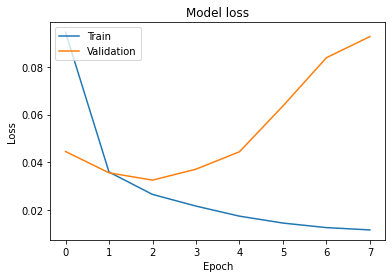

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

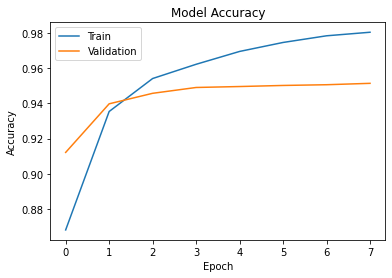

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X['val'])

pred_index_array = np.argmax(y_pred, axis=-1)
val_index_array = np.argmax(y['val'], axis=-1)

real_tag, pred_tag = prepare_to_eval(idx_tag_dict, val_index_array, pred_index_array)

print(f'Accuracy: {accuracy_score(real_tag, pred_tag)}')
print(f'F1-score: {f1_score(real_tag, pred_tag)}')

25/25 [==============================] - 0s 10ms/step
Accuracy: 0.9514246604949389
F1-score: 0.5580276608538786


In [ ]:
y_pred = model.predict(X['test'])

pred_index_array = np.argmax(y_pred, axis=-1)
test_index_array = np.argmax(y['test'], axis=-1)

real_tag, pred_tag = prepare_to_eval(idx_tag_dict, test_index_array, pred_index_array)

print(f'Accuracy: {accuracy_score(real_tag, pred_tag)}')
print(f'F1-score: {f1_score(real_tag, pred_tag)}')

49/49 [==============================] - 1s 11ms/step
Accuracy: 0.9498216923021505
F1-score: 0.5397994679762635


In [ ]:
print(classification_report(real_tag, pred_tag, zero_division=0))

                precision    recall  f1-score   support

         Actor       0.83      0.84      0.84       967
         Award       0.28      0.34      0.31        62
Character_Name       0.52      0.37      0.43       216
      Director       0.66      0.73      0.69       357
         Genre       0.54      0.64      0.59       684
       Opinion       0.34      0.19      0.24       165
        Origin       0.18      0.21      0.20       157
          Plot       0.25      0.34      0.29      1321
         Quote       0.07      0.16      0.10        19
  Relationship       0.30      0.36      0.32       134
    Soundtrack       0.00      0.00      0.00        11
          Year       0.89      0.92      0.91       500

     micro avg       0.51      0.57      0.54      4593
     macro avg       0.41      0.42      0.41      4593
  weighted avg       0.53      0.57      0.55      4593

